In [1]:
pip install xgboost scikit-learn pyswarm

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from pyswarm import pso

# Load dataset
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/murdiantasriel/Ale/main/mcs_ds_edited_iter_shuffled.csv')

In [3]:
df

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943
...,...,...,...,...,...,...
102,18,23,100,20,1.287472,0.375227
103,14,17,200,60,0.899102,0.231822
104,15,20,100,50,1.171140,0.372001
105,20,20,100,40,1.234493,0.599834


In [20]:
df.isna().sum()

anchor_ratio    0
trans_range     0
node_density    0
iterations      0
ale             0
sd_ale          0
dtype: int64

In [4]:
# Prepare the data
X = df[['anchor_ratio', 'trans_range', 'node_density', 'iterations']]
y = df['ale']


#xgboost x pso

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the objective function for PSO
def objective(params):
    learning_rate, max_depth, n_estimators, colsample_bytree = params
    model = xgb.XGBRegressor(objective='reg:squarederror',
                             learning_rate=learning_rate,
                             max_depth=int(max_depth),
                             n_estimators=int(n_estimators),
                             colsample_bytree=colsample_bytree,
                             random_state=42)
    # Using cross-validation to evaluate the model
    score = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return score


In [9]:
from sklearn.metrics import mean_squared_error
bounds = [(0.01, 0.3),   # learning_rate
          (3, 10),       # max_depth
          (50, 500),     # n_estimators
          (0.3, 0.9)]    # colsample_bytree

# Perform PSO
best_params, best_score = pso(objective, lb=[b[0] for b in bounds], ub=[b[1] for b in bounds], swarmsize=20, maxiter=30)

# Print the best parameters and best score
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror',
                              learning_rate=best_params[0],
                              max_depth=int(best_params[1]),
                              n_estimators=int(best_params[2]),
                              colsample_bytree=best_params[3],
                              random_state=42)
best_model.fit(X_train, y_train)

Stopping search: Swarm best objective change less than 1e-08
Best Parameters: [2.84452478e-01 3.00000000e+00 5.00000000e+02 3.69847514e-01]
Best Score: 0.041533451920464357


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.36984751432986446, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2844524784216498, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
print(f"Train Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")



Train Mean Squared Error: 0.01477371175150271
Test Mean Squared Error: 0.04632543682402676


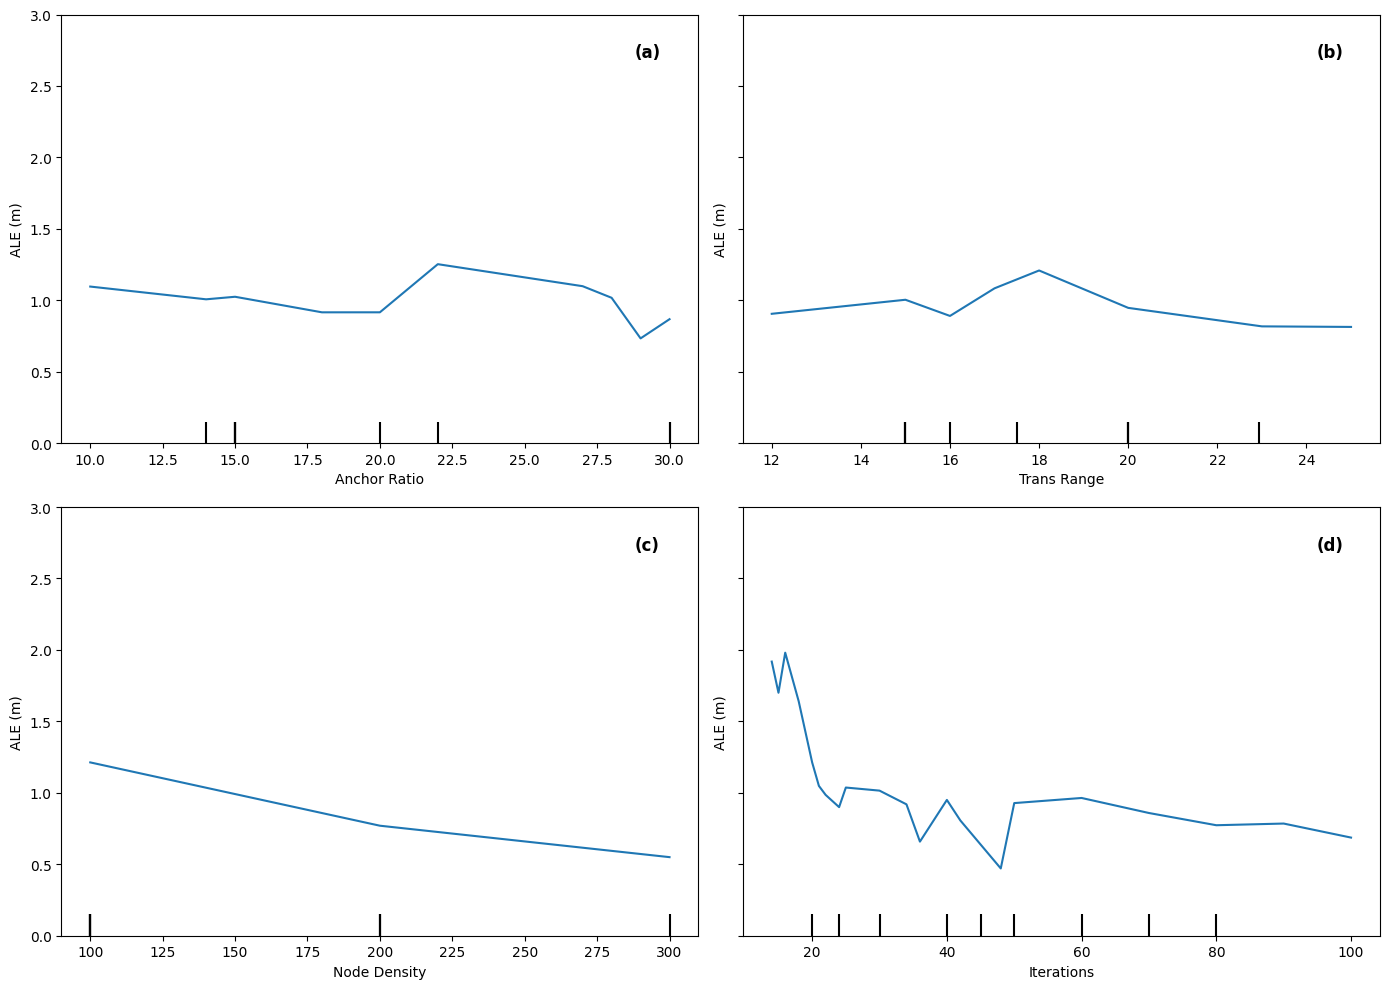

In [11]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Plot partial dependence plots
features = ['anchor_ratio', 'trans_range', 'node_density', 'iterations']

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
PartialDependenceDisplay.from_estimator(best_model, X_train, features, grid_resolution=50, ax=ax)

# Customize and save the plot
for i, axi in enumerate(ax.flatten()):
    axi.set_ylabel('ALE (m)')
    axi.set_xlabel(features[i].replace('_', ' ').title())
    axi.set_ylim(0, 3)
    axi.set_title('')
    axi.annotate(f'({chr(97 + i)})', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, weight='bold')

fig.tight_layout()
plt.show()


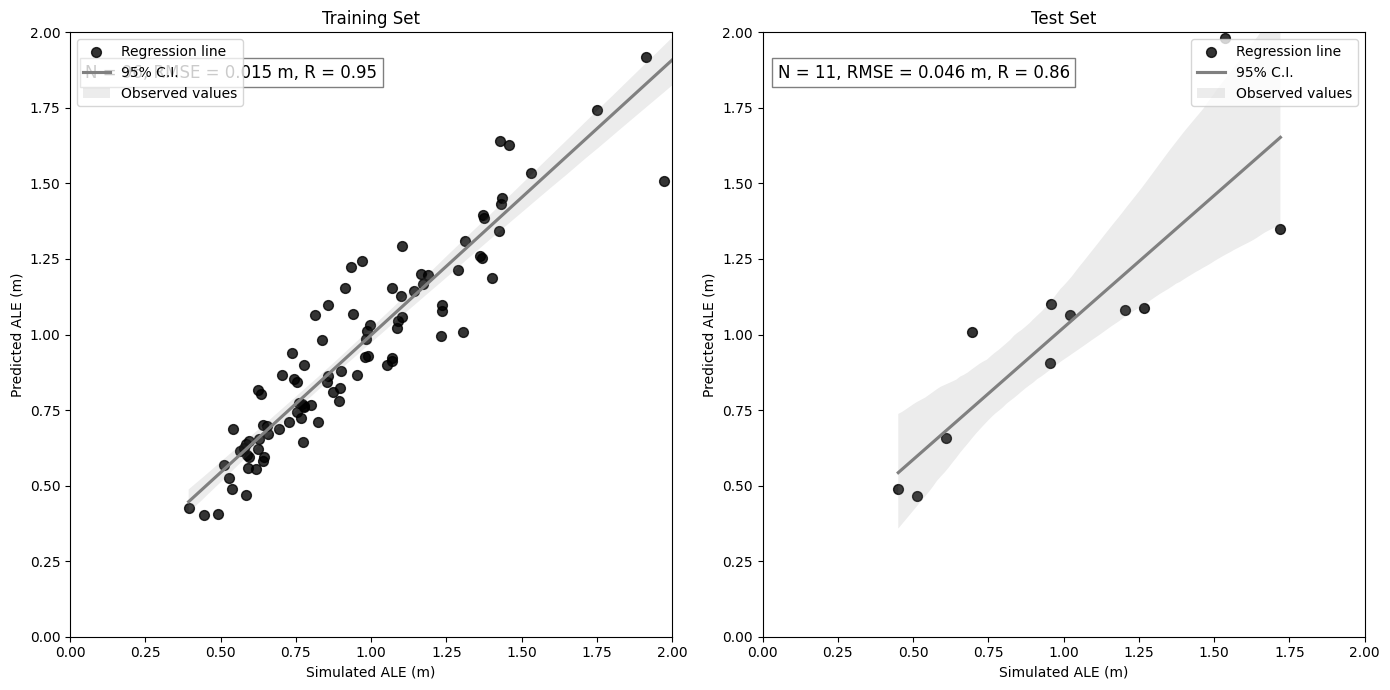

In [13]:
# Function to plot regression with confidence interval
import seaborn as sns
def plot_regression(y_true, y_pred, mse, r, ax, title):
    sns.regplot(x=y_true, y=y_pred, ax=ax, ci=95, scatter_kws={'s': 50, 'color': 'black'}, line_kws={'color': 'gray'})
    ax.set_xlabel('Simulated ALE (m)')
    ax.set_ylabel('Predicted ALE (m)')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.text(0.05, 1.85, f'N = {len(y_true)}, RMSE = {mse:.3f} m, R = {r:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax.legend(['Regression line', '95% C.I.', 'Observed values'])
    ax.set_title(title)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

plot_regression(y_train, y_train_pred, mse_train, r_train, axs[0], 'Training Set')
plot_regression(y_test, y_test_pred, mse_test, r_test, axs[1], 'Test Set')

plt.tight_layout()
plt.show()

#SVR

Train Mean Squared Error: 0.04052090870831871
Test Mean Squared Error: 0.04299198555746952


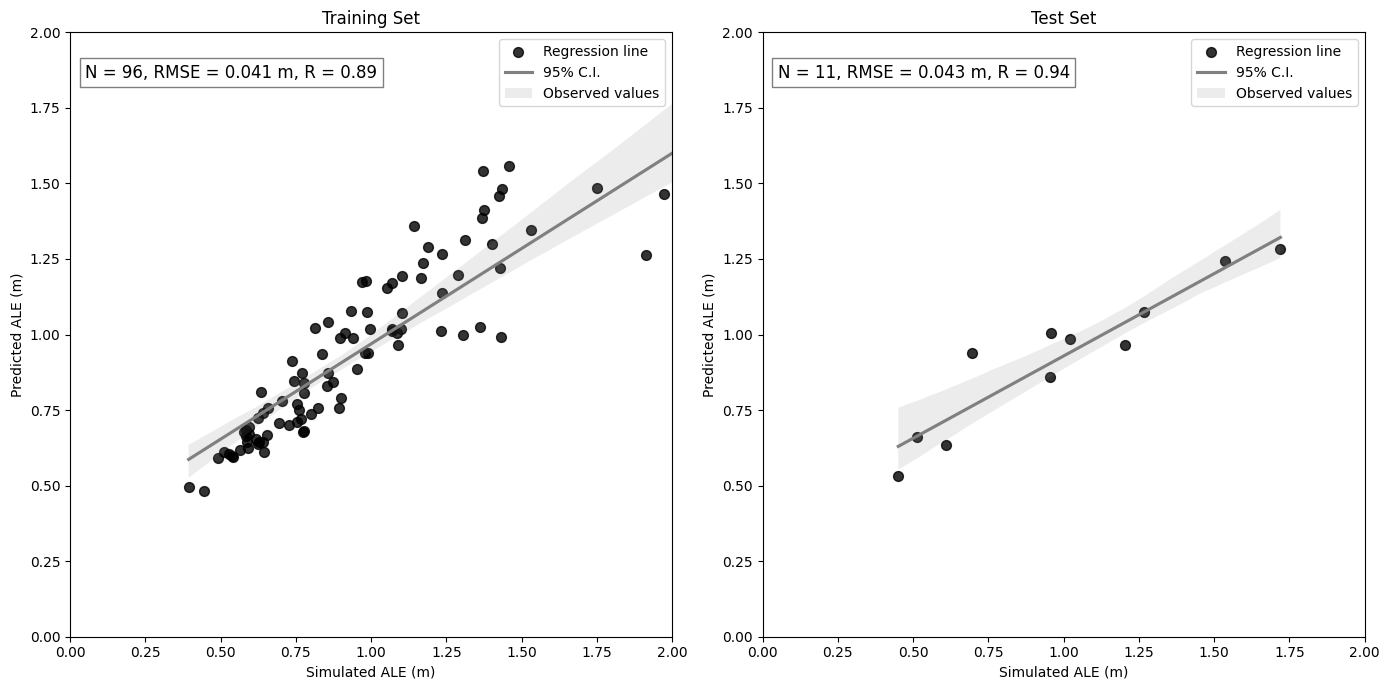

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


# Prepare the data
X = df[['anchor_ratio', 'trans_range', 'node_density', 'iterations']]
y = df['ale']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = svr_model.predict(X_train_scaled)
y_test_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
print(f"Train Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")

# Function to plot regression with confidence interval
def plot_regression(y_true, y_pred, mse, r, ax, title):
    sns.regplot(x=y_true, y=y_pred, ax=ax, ci=95, scatter_kws={'s': 50, 'color': 'black'}, line_kws={'color': 'gray'})
    ax.set_xlabel('Simulated ALE (m)')
    ax.set_ylabel('Predicted ALE (m)')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.text(0.05, 1.85, f'N = {len(y_true)}, RMSE = {mse:.3f} m, R = {r:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax.legend(['Regression line', '95% C.I.', 'Observed values'])
    ax.set_title(title)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

plot_regression(y_train, y_train_pred, mse_train, r_train, axs[0], 'Training Set')
plot_regression(y_test, y_test_pred, mse_test, r_test, axs[1], 'Test Set')

plt.tight_layout()
plt.show()


#SVR x PSO

Stopping search: maximum iterations reached --> 50
Best parameters found by PSO: C=1000.0, epsilon=0.0437899703652758
Train Mean Squared Error: 0.007761758413146773
Test Mean Squared Error: 0.06654427737932704


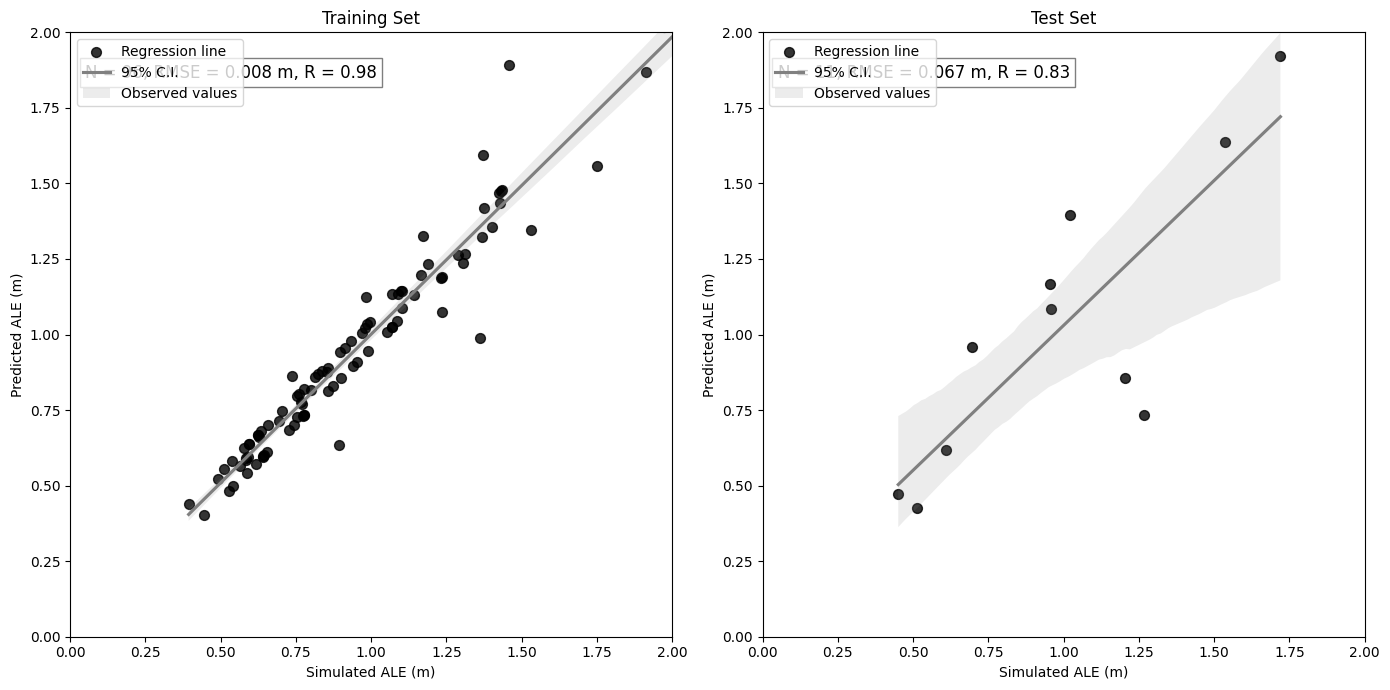

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from pyswarm import pso

# Assuming df is already loaded with your data
# df = pd.read_csv('path_to_your_data.csv')

# Prepare the data
X = df[['anchor_ratio', 'trans_range', 'node_density', 'iterations']]
y = df['ale']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Objective function for PSO
def objective(params):
    C, epsilon = params
    svr_model = SVR(kernel='rbf', C=C, epsilon=epsilon)
    svr_model.fit(X_train_scaled, y_train)
    y_train_pred = svr_model.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train, y_train_pred)
    return mse_train

# Define the bounds for C and epsilon
lb = [0.1, 0.01]  # lower bounds of C and epsilon
ub = [1000, 1.0]  # upper bounds of C and epsilon

# Run PSO
best_params, _ = pso(objective, lb, ub, swarmsize=30, maxiter=50)

# Train the SVR model with best parameters found by PSO
C_opt, epsilon_opt = best_params
svr_model = SVR(kernel='rbf', C=C_opt, epsilon=epsilon_opt)
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = svr_model.predict(X_train_scaled)
y_test_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
print(f"Best parameters found by PSO: C={C_opt}, epsilon={epsilon_opt}")
print(f"Train Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")

# Function to plot regression with confidence interval
def plot_regression(y_true, y_pred, mse, r, ax, title):
    sns.regplot(x=y_true, y=y_pred, ax=ax, ci=95, scatter_kws={'s': 50, 'color': 'black'}, line_kws={'color': 'gray'})
    ax.set_xlabel('Simulated ALE (m)')
    ax.set_ylabel('Predicted ALE (m)')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.text(0.05, 1.85, f'N = {len(y_true)}, RMSE = {mse:.3f} m, R = {r:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax.legend(['Regression line', '95% C.I.', 'Observed values'])
    ax.set_title(title)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

plot_regression(y_train, y_train_pred, mse_train, r_train, axs[0], 'Training Set')
plot_regression(y_test, y_test_pred, mse_test, r_test, axs[1], 'Test Set')

plt.tight_layout()
plt.show()


#xgboost x optuna

In [15]:
!pip install optuna

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import optuna
from optuna.samplers import TPESampler


# Prepare the data
X = df[['anchor_ratio', 'trans_range', 'node_density', 'iterations']]
y = df['ale']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
    }

    model = XGBRegressor(**param, objective='reg:squarederror')
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

# Get the best model from the study
best_params = study.best_params
best_xgb = XGBRegressor(**best_params, objective='reg:squarederror')
best_xgb.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found: ", best_params)
print("Best test mean squared error: ", study.best_value)

# Make predictions with the best model
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r_train = np.corrcoef(y_train, y_train_pred)[0, 1]
r_test = np.corrcoef(y_test, y_test_pred)[0, 1]
print(f"Train Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")

[I 2024-06-24 11:33:42,699] A new study created in memory with name: no-name-c53af4bc-4c42-4873-8a75-4810ace602e3
[I 2024-06-24 11:33:42,994] Trial 0 finished with value: 0.04059618161976022 and parameters: {'n_estimators': 124, 'learning_rate': 0.11709020042248507, 'max_depth': 7, 'subsample': 0.9170860524135473, 'colsample_bytree': 0.9069662799219627}. Best is trial 0 with value: 0.04059618161976022.
[I 2024-06-24 11:33:44,257] Trial 1 finished with value: 0.030797565602912445 and parameters: {'n_estimators': 77, 'learning_rate': 0.12204198619467697, 'max_depth': 4, 'subsample': 0.8264089716606455, 'colsample_bytree': 0.877113853559941}. Best is trial 1 with value: 0.030797565602912445.
[I 2024-06-24 11:33:44,549] Trial 2 finished with value: 0.027651665022346294 and parameters: {'n_estimators': 107, 'learning_rate': 0.06611789509783696, 'max_depth': 4, 'subsample': 0.9400000288897634, 'colsample_bytree': 0.9677237718051783}. Best is trial 2 with value: 0.027651665022346294.
[I 2024-

Best parameters found:  {'n_estimators': 183, 'learning_rate': 0.10001493794040311, 'max_depth': 4, 'subsample': 0.99500073008139, 'colsample_bytree': 0.805908110250958}
Best test mean squared error:  0.019391555389329095
Train Mean Squared Error: 0.0033665845309849966
Test Mean Squared Error: 0.019391555389329095


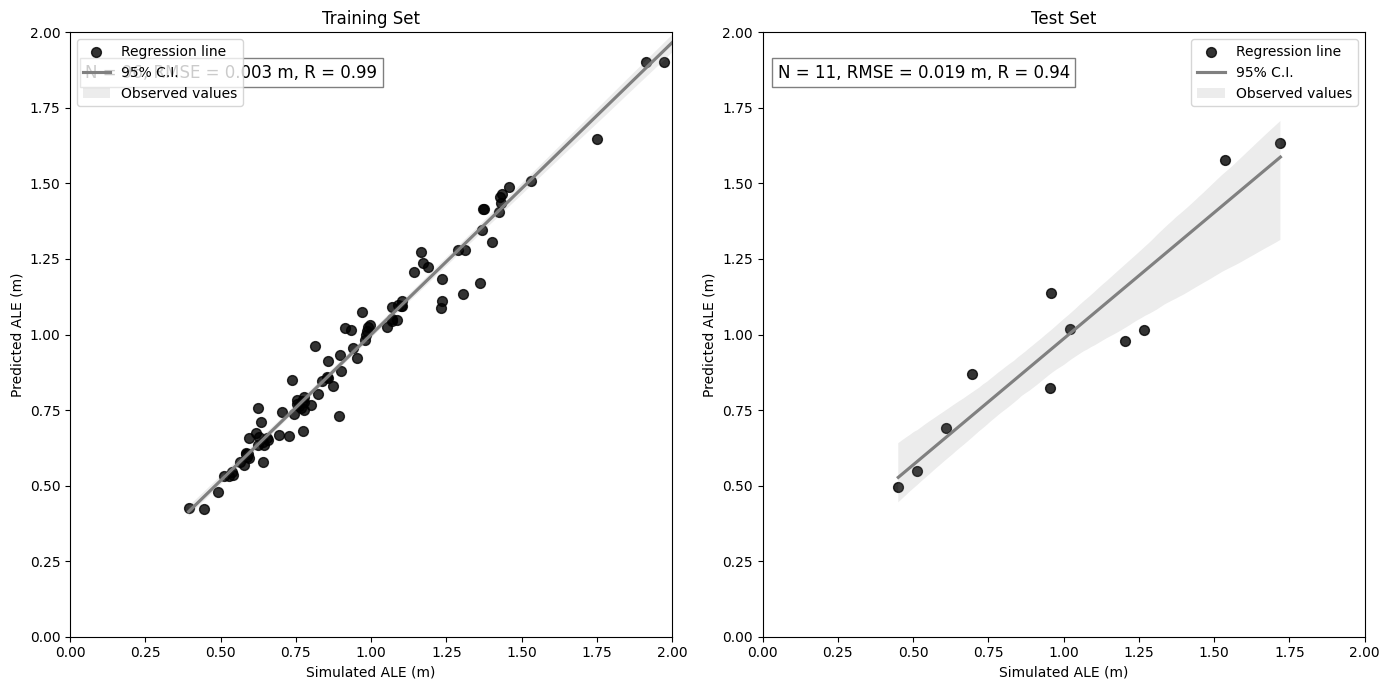

In [17]:
# Function to plot regression with confidence interval
def plot_regression(y_true, y_pred, mse, r, ax, title):
    sns.regplot(x=y_true, y=y_pred, ax=ax, ci=95, scatter_kws={'s': 50, 'color': 'black'}, line_kws={'color': 'gray'})
    ax.set_xlabel('Simulated ALE (m)')
    ax.set_ylabel('Predicted ALE (m)')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.text(0.05, 1.85, f'N = {len(y_true)}, RMSE = {mse:.3f} m, R = {r:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax.legend(['Regression line', '95% C.I.', 'Observed values'])
    ax.set_title(title)

# Plot the regression results
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

plot_regression(y_train, y_train_pred, mse_train, r_train, axs[0], 'Training Set')
plot_regression(y_test, y_test_pred, mse_test, r_test, axs[1], 'Test Set')

plt.tight_layout()
plt.show()

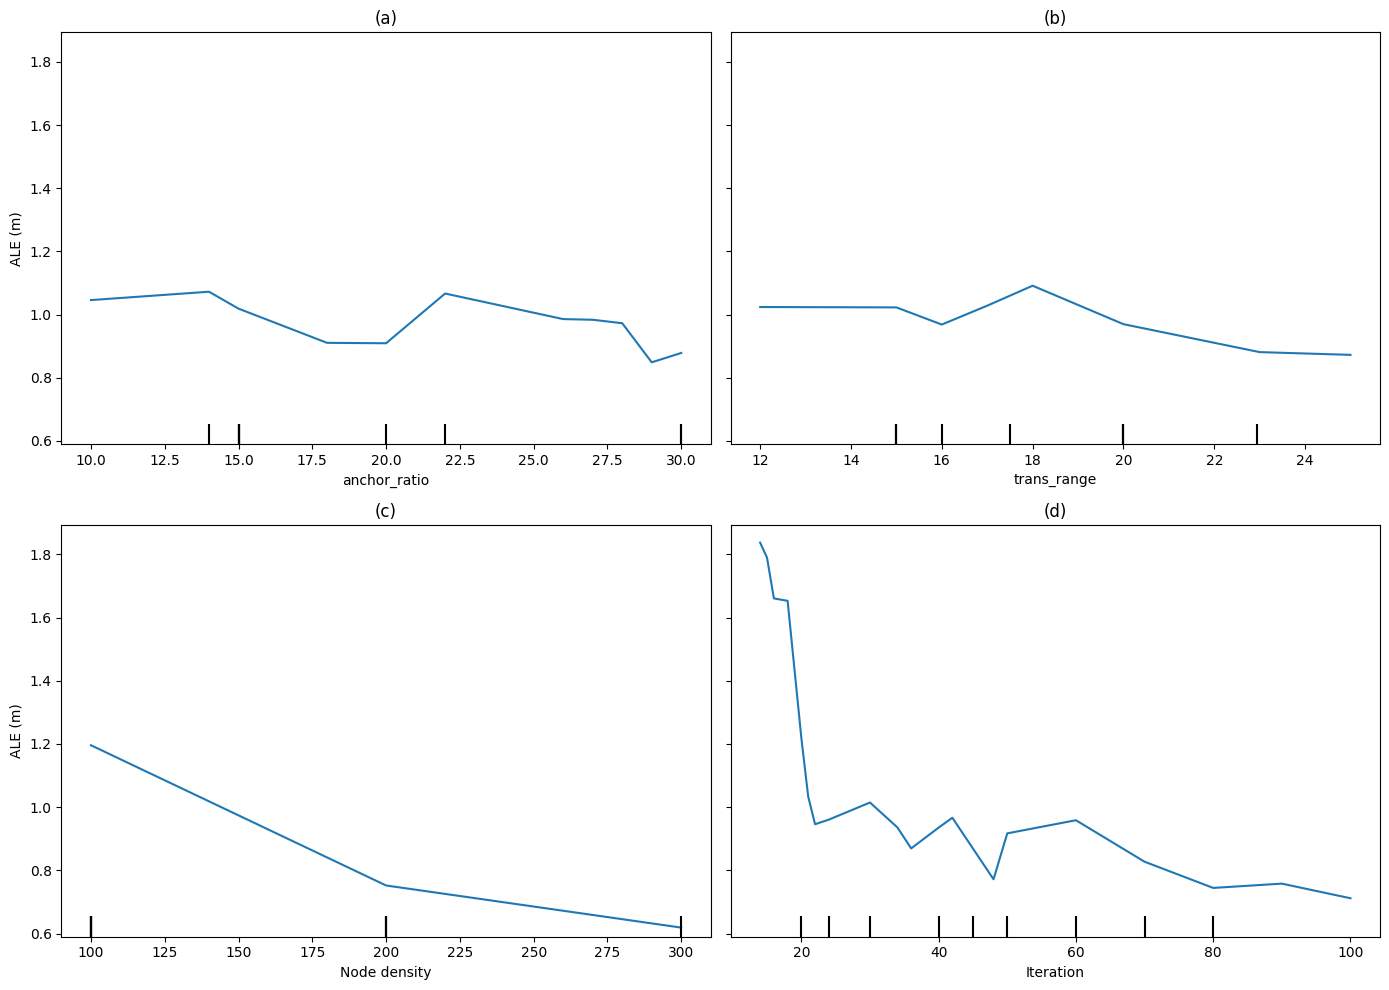

In [18]:
# Partial Dependence Plots
features = ['anchor_ratio', 'trans_range', 'node_density', 'iterations']
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

PartialDependenceDisplay.from_estimator(best_xgb, X_train, features, ax=ax)

# Customize and save the plot
ax[0, 0].set_title("(a)")
ax[0, 1].set_title("(b)")
ax[1, 0].set_title("(c)")
ax[1, 1].set_title("(d)")
ax[0, 0].set_ylabel("ALE (m)")
ax[1, 0].set_ylabel("ALE (m)")
ax[1, 0].set_xlabel("Node density")
ax[1, 1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()
